📊 Comprehensive Report: Grocery Inventory Analysis¶
🧰 Methodology & Processing

    Data Cleaning:
        Converted Date_Received and Expiration_Date columns to datetime.
        Fixed negative or missing Storage_Duration_Days using date differences.
        Removed rows with still-missing or negative values after correction.

    Feature Engineering:
        Calculated storage duration (Storage_Duration_Days).
        Calculated total value (Unit_Price_in_$ × Stock_Quantity).

    Aggregation & Grouping:
        Average storage duration by category.
        Average unit price by category.
        Total inventory value by category.

    Visualization:
        Bar charts of average storage duration and unit price.
        Pie chart of total inventory value.
        Scatter plot of unit price vs. storage duration by category.

🔍 Key Findings
Question 	Finding
Category with the most products 	Fruits & Vegetables (332 products)
Longest average storage duration 	Oils & Fats (~141 days)
Shortest average storage duration 	Seafood (~99 days)
Most expensive category (average unit price) 	Beverages (~$16.05)
Top inventory value category 	Displayed in pie chart

✅ Recommendations

    Control Cost and Stock:
        Monitor expensive categories like Beverages for cost-efficiency.
        Combine pricing with sales volume to identify imbalances.

    Optimize Shelf Life:
        High average duration may suggest durability or slow turnover.
        Categories like Seafood require frequent stock refresh due to shorter shelf life.

    Expand Analysis:
        Include supplier-level insights for better vendor management.
        Correlate sales and inventory data to identify sales opportunities.

Report generated with Python and Plotly from a cleaned and validated grocery inventory dataset.

In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grocery-inventory/Grocery_Inventory new v1.csv


# Import the dataset

In [92]:
grocery = pd.read_csv("/kaggle/input/grocery-inventory/Grocery_Inventory new v1.csv")

# See the result
grocery

,Product_Name,Catagory,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Sales_Volume,Inventory_Turnover_Rate,percentage
0,Bell Pepper,Fruits & Vegetables,Eimbee,20 Pennsylvania Parkway,Discontinued,29-017-6255,43-348-2450,3/1/2024,1/6/2025,1/31/2025,46,64,17,$4.60,96,55,1.96%
1,Vegetable Oil,Oils & Fats,Digitube,03643 Oakridge Lane,Backordered,79-569-8856,04-854-7165,4/1/2024,5/19/2024,6/11/2024,51,87,86,$2.00,24,83,0.91%
2,Parmesan Cheese,Dairy,BlogXS,73 Graedel Street,Discontinued,28-146-2641,82-995-0739,4/1/2024,12/21/2024,4/8/2024,38,67,66,$12.00,35,24,1.36%
3,Carrot,Fruits & Vegetables,Avaveo,44801 Myrtle Center,Discontinued,11-581-9869,22-867-3079,5/1/2024,12/12/2024,9/26/2024,51,60,98,$1.50,44,95,1.36%
4,Garlic,Fruits & Vegetables,Katz,6195 Monterey Center,Discontinued,13-202-4809,24-281-7685,5/1/2024,7/28/2024,5/20/2024,27,22,89,$7.00,91,77,2.17%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,Parmesan Cheese,Dairy,Yakidoo,0 Fordem Place,Backordered,67-984-5368,39-714-7313,9/27/2024,10/4/2024,7/28/2024,52,56,34,$12.00,31,69,024%
986,Raw Sugar,Grains & Pulses,Flipopia,365 Vera Terrace,Active,44-782-1395,54-132-9762,9/29/2024,6/26/2024,11/17/2024,72,72,68,$1.50,39,78,-123%
987,Cabbage,Fruits & Vegetables,Topdrive,43 Washington Street,Discontinued,75-927-9108,27-406-7972,9/29/2024,6/17/2024,7/2/2024,24,32,17,$1.00,55,72,-100%
988,Green Beans,Fruits & Vegetables,Gigazoom,37 Browning Trail,Discontinued,78-614-4402,51-014-4287,9/30/2024,2/14/2025,4/25/2024,81,99,28,$2.00,20,85,-031%


# Missing values

In [93]:
grocery.isnull().sum()
grocery.loc[grocery['Product_Name'] == 'Cabbage', 'Catagory'] = 'Fruits & Vegetables'

In [94]:
grocery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Product_Name             990 non-null    object
 1   Catagory                 990 non-null    object
 2   Supplier_Name            990 non-null    object
 3   Warehouse_Location       990 non-null    object
 4   Status                   990 non-null    object
 5   Product_ID               990 non-null    object
 6   Supplier_ID              990 non-null    object
 7   Date_Received            990 non-null    object
 8   Last_Order_Date          990 non-null    object
 9   Expiration_Date          990 non-null    object
 10  Stock_Quantity           990 non-null    int64 
 11  Reorder_Level            990 non-null    int64 
 12  Reorder_Quantity         990 non-null    int64 
 13  Unit_Price               990 non-null    object
 14  Sales_Volume             990 non-null    i

# טיפול בתאריכים

In [95]:
grocery['Date_Received'] = pd.to_datetime(grocery['Date_Received'], dayfirst=True, errors='coerce')
grocery['Last_Order_Date'] = pd.to_datetime(grocery['Last_Order_Date'], dayfirst=True, errors='coerce')
grocery['Expiration_Date'] = pd.to_datetime(grocery['Expiration_Date'], dayfirst=True, errors='coerce')

date_columns = ['Date_Received', 'Last_Order_Date', 'Expiration_Date']

def safe_replace_year_adjust(dt, new_year=2025):
    if pd.isna(dt):
        return pd.NaT
    try:
        return dt.replace(year=new_year)
    except ValueError:
        # שינוי רק למקרה של 29 בפברואר
        if dt.month == 2 and dt.day == 29:
            return dt.replace(year=new_year, day=28)
        return pd.NaT
        
for col in date_columns:
    print(f"{col} years: {grocery[col].dt.year.unique()}")

# ננסה להריץ שוב את ההחלפה רק על השורות שעדיין 2024
for col in date_columns:
    grocery.loc[
        grocery[col].dt.year == 2024, col
    ] = grocery.loc[
        grocery[col].dt.year == 2024, col
    ].apply(lambda dt: safe_replace_year_adjust(dt, 2025))


Date_Received years: [2024. 2025.   nan]
Last_Order_Date years: [2025.   nan 2024.]
Expiration_Date years: [2025 2024]


/tmp/ipykernel_31/3070368735.py:3: UserWarning:

Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.



# Expiration date check

In [96]:
grocery['Storage_Duration_Days'] = (grocery['Expiration_Date'] - grocery['Date_Received']).dt.days
grocery['Storage_Alert'] = grocery['Storage_Duration_Days'].apply(
    lambda x: 'Less than 30 days' if pd.notnull(x) and x < 30 else '')
today = pd.Timestamp.today()
grocery['Storage_Status'] = grocery['Expiration_Date'].apply(
    lambda x: 'Expired' if pd.notnull(x) and x < today else 'OK')

# חשב מחדש את זמן האחסון רק בשורות שבהן הזמן שלילי או חסר, תוך התחשבות ב-NaN
mask = grocery['Storage_Duration_Days'].notna() & (grocery['Storage_Duration_Days'] < 0) | grocery['Storage_Duration_Days'].isna()

# תיקון זמן האחסון
grocery.loc[mask, 'Storage_Duration_Days'] = (
    (grocery.loc[mask, 'Expiration_Date'] - grocery.loc[mask, 'Date_Received']).dt.days
)
# סינון שורות לא תקינות
grocery_cleaned = grocery[grocery['Storage_Duration_Days'].notna() & (grocery['Storage_Duration_Days'] >= 0)]

grocery_cleaned

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal



,Product_Name,Catagory,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Sales_Volume,Inventory_Turnover_Rate,percentage,Storage_Duration_Days,Storage_Alert,Storage_Status
0,Bell Pepper,Fruits & Vegetables,Eimbee,20 Pennsylvania Parkway,Discontinued,29-017-6255,43-348-2450,2025-01-03,2025-06-01,2025-01-31,46,64,17,$4.60,96,55,1.96%,28.0,Less than 30 days,Expired
1,Vegetable Oil,Oils & Fats,Digitube,03643 Oakridge Lane,Backordered,79-569-8856,04-854-7165,2025-01-04,NaT,2025-06-11,51,87,86,$2.00,24,83,0.91%,158.0,,OK
2,Parmesan Cheese,Dairy,BlogXS,73 Graedel Street,Discontinued,28-146-2641,82-995-0739,2025-01-04,NaT,2025-04-08,38,67,66,$12.00,35,24,1.36%,94.0,,Expired
3,Carrot,Fruits & Vegetables,Avaveo,44801 Myrtle Center,Discontinued,11-581-9869,22-867-3079,2025-01-05,2025-12-12,2025-09-26,51,60,98,$1.50,44,95,1.36%,264.0,,OK
4,Garlic,Fruits & Vegetables,Katz,6195 Monterey Center,Discontinued,13-202-4809,24-281-7685,2025-01-05,NaT,2025-05-20,27,22,89,$7.00,91,77,2.17%,135.0,,Expired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Papaya,Fruits & Vegetables,Ntag,227 Tennyson Plaza,Discontinued,31-608-1445,75-286-4153,2025-09-02,NaT,2025-12-14,84,28,29,$4.40,54,32,024%,103.0,,OK
377,Egg (Quail),Dairy,Meejo,75 High Crossing Junction,Discontinued,70-206-4860,82-527-9395,2025-09-02,2025-11-03,2025-09-17,93,68,71,$0.80,30,37,041%,15.0,Less than 30 days,OK
381,Mozzarella Cheese,Dairy,Devpoint,4 Warbler Center,Discontinued,79-400-6216,83-361-7509,2025-10-02,2025-10-03,2025-10-02,16,56,13,$7.20,56,28,023%,0.0,Less than 30 days,OK
383,Pomegranate,Fruits & Vegetables,Meevee,03 Little Fleur Pass,Backordered,08-573-9997,95-734-4024,2025-10-02,2025-05-04,2025-12-02,26,1,9,$6.00,82,8,090%,61.0,,OK


# טיפול במחירים

In [97]:
grocery_cleaned['Unit_Price'] = grocery_cleaned['Unit_Price'].str.replace('$', '', regex=False).astype(float)
grocery_cleaned = grocery_cleaned.rename(columns={'Unit_Price': 'Unit_Price_in_$'})
grocery_cleaned

/tmp/ipykernel_31/976601286.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Product_Name,Catagory,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price_in_$,Sales_Volume,Inventory_Turnover_Rate,percentage,Storage_Duration_Days,Storage_Alert,Storage_Status
0,Bell Pepper,Fruits & Vegetables,Eimbee,20 Pennsylvania Parkway,Discontinued,29-017-6255,43-348-2450,2025-01-03,2025-06-01,2025-01-31,46,64,17,4.60,96,55,1.96%,28.0,Less than 30 days,Expired
1,Vegetable Oil,Oils & Fats,Digitube,03643 Oakridge Lane,Backordered,79-569-8856,04-854-7165,2025-01-04,NaT,2025-06-11,51,87,86,2.00,24,83,0.91%,158.0,,OK
2,Parmesan Cheese,Dairy,BlogXS,73 Graedel Street,Discontinued,28-146-2641,82-995-0739,2025-01-04,NaT,2025-04-08,38,67,66,12.00,35,24,1.36%,94.0,,Expired
3,Carrot,Fruits & Vegetables,Avaveo,44801 Myrtle Center,Discontinued,11-581-9869,22-867-3079,2025-01-05,2025-12-12,2025-09-26,51,60,98,1.50,44,95,1.36%,264.0,,OK
4,Garlic,Fruits & Vegetables,Katz,6195 Monterey Center,Discontinued,13-202-4809,24-281-7685,2025-01-05,NaT,2025-05-20,27,22,89,7.00,91,77,2.17%,135.0,,Expired
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Papaya,Fruits & Vegetables,Ntag,227 Tennyson Plaza,Discontinued,31-608-1445,75-286-4153,2025-09-02,NaT,2025-12-14,84,28,29,4.40,54,32,024%,103.0,,OK
377,Egg (Quail),Dairy,Meejo,75 High Crossing Junction,Discontinued,70-206-4860,82-527-9395,2025-09-02,2025-11-03,2025-09-17,93,68,71,0.80,30,37,041%,15.0,Less than 30 days,OK
381,Mozzarella Cheese,Dairy,Devpoint,4 Warbler Center,Discontinued,79-400-6216,83-361-7509,2025-10-02,2025-10-03,2025-10-02,16,56,13,7.20,56,28,023%,0.0,Less than 30 days,OK
383,Pomegranate,Fruits & Vegetables,Meevee,03 Little Fleur Pass,Backordered,08-573-9997,95-734-4024,2025-10-02,2025-05-04,2025-12-02,26,1,9,6.00,82,8,090%,61.0,,OK


# סטטיסטיקה תיאורית כללית

In [98]:
desc_stats = grocery_cleaned.describe()

# התפלגות קטגוריות

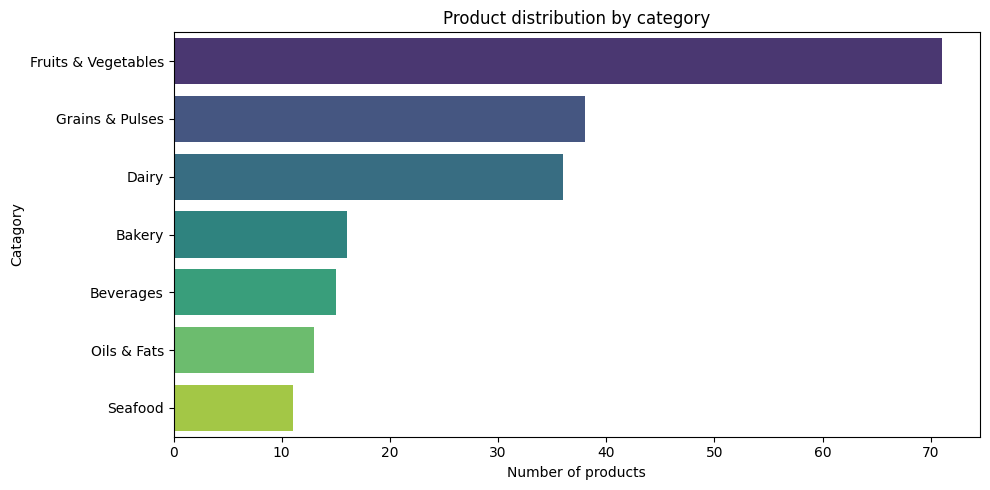

In [99]:
category_counts = grocery_cleaned['Catagory'].value_counts()

# גרף התפלגות קטגוריות
plt.figure(figsize=(10, 5))
sns.countplot(data=grocery_cleaned, y='Catagory', order=category_counts.index, palette='viridis')
plt.title('Product distribution by category')
plt.xlabel('Number of products')
plt.ylabel('Catagory')
plt.tight_layout()
plt.show()

# ממוצע מחיר לפי קטגוריה

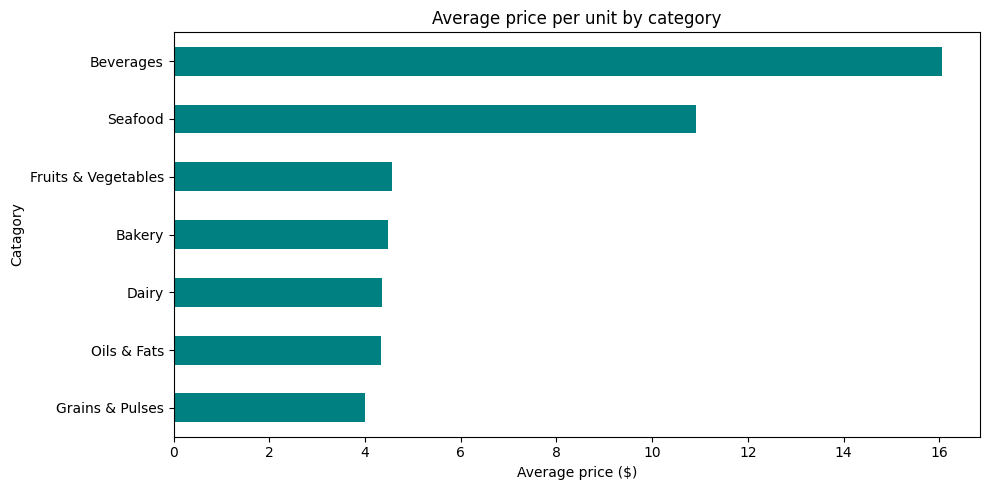

In [100]:
avg_price_per_category = grocery_cleaned.groupby('Catagory')['Unit_Price_in_$'].mean().sort_values()

# גרף ממוצע מחיר ליחידה לפי קטגוריה
plt.figure(figsize=(10, 5))
avg_price_per_category.plot(kind='barh', color='teal')
plt.title('Average price per unit by category')
plt.xlabel('Average price ($)')
plt.ylabel('Catagory')
plt.tight_layout()
plt.show()

# קשר בין מלאי למכירות

In [101]:
correlation_stock_sales = grocery_cleaned[['Stock_Quantity', 'Sales_Volume']].corr()

In [102]:
print("סטטיסטיקה תיאורית:\n", desc_stats)
print("\nמתאם בין כמות במלאי למכירות:\n", correlation_stock_sales)

סטטיסטיקה תיאורית:
              Date_Received                Last_Order_Date  \
count                  200                             94   
mean   2025-04-26 11:16:48  2025-07-10 09:57:26.808510720   
min    2025-01-02 00:00:00            2025-01-01 00:00:00   
25%    2025-02-08 00:00:00            2025-04-10 00:00:00   
50%    2025-04-10 00:00:00            2025-07-11 00:00:00   
75%    2025-06-16 18:00:00            2025-10-06 00:00:00   
max    2025-12-09 00:00:00            2025-12-12 00:00:00   
std                    NaN                            NaN   

           Expiration_Date  Stock_Quantity  Reorder_Level  Reorder_Quantity  \
count                  200      200.000000     200.000000        200.000000   
mean   2025-08-24 17:16:48       52.990000      49.945000         50.200000   
min    2025-01-31 00:00:00       11.000000       1.000000          1.000000   
25%    2025-06-24 18:00:00       28.500000      25.000000         23.000000   
50%    2025-09-08 00:00:00       50

# מספר המוצרים בכל קטגוריה

In [103]:
# ספור את מספר המוצרים בכל קטגוריה
category_counts = grocery_cleaned['Catagory'].value_counts().reset_index()
category_counts.columns = ['Category', 'Product_Count']

# צור גרף עמודות אינטראקטיבי
fig = px.bar(category_counts,
             x='Category',
             y='Product_Count',
             title='Interactive Comparison of Product Counts by Category',
             labels={'Product_Count': 'Number of Products', 'Category': 'Category'},
             hover_data=['Product_Count'])

fig.update_layout(xaxis_tickangle=-45)
fig.show()

# ממוצע זמן אחסון לפי קטגוריה

In [104]:
avg_storage_duration_cleaned = grocery_cleaned.groupby('Catagory')['Storage_Duration_Days'].mean().reset_index()
avg_storage_duration_cleaned.columns = ['Category', 'Average_Storage_Duration_Days']

# גרף אינטראקטיבי
fig = px.bar(avg_storage_duration_cleaned,
             x='Category',
             y='Average_Storage_Duration_Days',
             title='Average Storage Duration by Category (Cleaned Data)',
             labels={'Average_Storage_Duration_Days': 'Average Storage Duration (Days)', 'Category': 'Category'},
             hover_data=['Average_Storage_Duration_Days'])

fig.update_layout(xaxis_tickangle=-45)
fig.show()

# חישוב מחיר ממוצע לפי קטגוריה

In [105]:
avg_price_per_category = grocery_cleaned.groupby('Catagory')['Unit_Price_in_$'].mean().reset_index()
avg_price_per_category.columns = ['Category', 'Average_Unit_Price']

# גרף אינטראקטיבי
fig = px.bar(avg_price_per_category,
             x='Category',
             y='Average_Unit_Price',
             title='Average Unit Price by Category',
             labels={'Average_Unit_Price': 'Average Price ($)', 'Category': 'Category'},
             hover_data=['Average_Unit_Price'])

fig.update_layout(xaxis_tickangle=-45)
fig.show()

# חישוב העלות הכוללת לכל קטגוריה

In [106]:
grocery_cleaned['Total_Value'] = grocery_cleaned['Unit_Price_in_$'] * grocery_cleaned['Stock_Quantity']
value_per_category = grocery_cleaned.groupby('Catagory')['Total_Value'].sum().reset_index()

# גרף עוגה
fig = px.pie(value_per_category,
             names='Catagory',
             values='Total_Value',
             title='Total Inventory Value by Category',
             hole=0.4)
fig.show()


# הקשר בין יוקר המוצר לאורך החיים שלו במדף

In [107]:
fig = px.scatter(grocery_cleaned,
                 x='Storage_Duration_Days',
                 y='Unit_Price_in_$',
                 color='Catagory',
                 size='Stock_Quantity',
                 title='Unit Price vs. Storage Duration by Category',
                 hover_data=['Product_Name'])
fig.show()


# מציג את הפיזור, החציון והחריגות של מחירי המוצרים בכל קטגוריה

In [108]:
fig = px.box(grocery_cleaned,
             x='Catagory',
             y='Unit_Price_in_$',
             title='Price Distribution by Category',
             points='all')  # מציג גם נקודות חריגות
fig.update_layout(xaxis_tickangle=-45)
fig.show()


# שמירה לקובץ חדש

In [109]:
grocery_cleaned.to_csv("Grocery_Inventory_data.csv", index=False)